## Import Libraries

In [1]:
print("\n--- IMPORTING LIBRARIES ---")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import os

# Configuration to display all columns
pd.set_option('display.max_columns', None)



--- IMPORTING LIBRARIES ---


## Phase 1: Data Ingestion & Clinical Sanitation

### Objective
Transform raw, error-prone clinical encounter data into a reliable analytical dataset suitable for downstream analysis and modeling.

### Rationale

Clinical databases are inherently messy due to:
- Non-standard representations of missing values
- Legacy coding systems
- Data entry errors
- Administrative outcomes (e.g., death) that invalidate predictive targets

This phase establishes a **clean analytical baseline** by enforcing consistent null handling, removing structurally invalid records, and stabilizing categorical identifiers.

### Key Decisions

1. **Standardizing Missing Values**
   - The dataset uses `'?'` to represent missing values.
   - These are converted to NumPy `NaN` to enable proper statistical handling.

2. **Dropping the `weight` Column**
   - The `weight` feature exhibits >90% missingness.
   - Imputation would be statistically meaningless and introduce bias.
   - This limitation is documented as a data quality constraint.

3. **Handling Invalid Gender Values**
   - `Unknown/Invalid` is treated as missing, not as a valid category.

4. **Removing Deceased Patients**
   - Patients who expire or enter hospice cannot be readmitted.
   - Including them would inject label noise into readmission analysis.
   - Discharge disposition codes corresponding to death/hospice are identified via `IDs_mapping.csv`.

5. **Deduplication**
   - Exact duplicate rows indicate data entry or ETL errors and are removed.

6. **Stabilizing Categorical Identifiers**
   - Administrative ID columns are cast to strings to prevent numerical misinterpretation.

The output of this phase is a **sanitized encounter-level dataset**, persisted to disk for reproducibility.

In [2]:
print("\n--- STARTING PHASE 1: DATA INGESTION & CLINICAL SANITATION ---")

def load_and_sanitize_data(data_path, id_map_path):
    """
    Phase 1 pipeline:
    - Standardize missing values
    - Audit schema and data quality
    - Drop structurally invalid features
    - Remove deceased/hospice encounters
    - Deduplicate exact duplicates
    - Identify oral medication columns
    """

    # 1. Load raw dataset and standardize missing values
    
    df = pd.read_csv(data_path, na_values='?')
    print(f"Dataset loaded successfully. Initial shape: {df.shape}")

    # 2. Initial Audit
    
    print("\n--- SCHEMA OVERVIEW (.info) ---")
    df.info()
    print("\n--- NUMERICAL SUMMARY (.describe) ---")
    print(df.describe())
    print("\n--- COLUMN SCHEMA ---")
    print(df.columns.tolist())

    # 3. Identify Oral Medication Columns
    
    oral_medications = [
        'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
        'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
        'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
        'examide','citoglipton','glyburide-metformin','glipizide-metformin',
        'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'
    ]
    oral_medications = [col for col in oral_medications if col in df.columns]
    print(f"Identified {len(oral_medications)} oral diabetes medication columns.")

    # 4. Drop Weight Column if >90% Missing
    
    if 'weight' in df.columns:
        missing_rate = df['weight'].isna().mean()
        print(f"Weight missingness: {missing_rate:.2%}")
        if missing_rate > 0.90:
            df.drop(columns=['weight'], inplace=True)
            print("Dropped 'weight' column due to excessive missingness (>90%).")
            df.attrs['data_quality_limitation'] = "Weight column dropped due to >90% missing values."


    # 5. Handle Invalid Gender Values
    
    if 'gender' in df.columns:
        invalid_count = (df['gender'] == 'Unknown/Invalid').sum()
        df.loc[df['gender'] == 'Unknown/Invalid', 'gender'] = np.nan
        print(f"Converted {invalid_count} invalid gender entries to NaN.")

    # 6. Remove Deceased / Hospice Patients

    # Read IDs mapping CSV without headers to handle semi-structured file
    id_map = pd.read_csv(id_map_path, header=None, names=['id', 'description'], dtype=str)

    # Find rows corresponding to 'discharge_disposition_id'
    start_idx = id_map[id_map['id'] == 'discharge_disposition_id'].index[0] + 1
    end_idx = id_map[id_map['id'] == 'admission_source_id'].index[0]

    discharge_section = id_map.iloc[start_idx:end_idx].copy()
    discharge_section['id'] = pd.to_numeric(discharge_section['id'], errors='coerce')

    # Identify expired/hospice codes
    expired_codes = discharge_section[
        discharge_section['description'].str.contains("Expired|Hospice", case=False, na=False)
    ]['id'].tolist()

    before_filter = len(df)
    df = df[~df['discharge_disposition_id'].isin(expired_codes)]
    print(f"Removed {before_filter - len(df)} deceased or hospice encounters.")

    # 7. Deduplicate Exact Rows

    before_dedup = len(df)
    df.drop_duplicates(inplace=True)
    print(f"Removed {before_dedup - len(df)} exact duplicate rows.")

    # 8. Stabilize Categorical Identifiers (as string for consistency)
    
    categorical_ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
    for col in categorical_ids:
        if col in df.columns:
            df[col] = df[col].astype(str)

    print(f"\nPhase 1 complete. Final dataset shape: {df.shape}")
    return df


# EXECUTION

DATA_PATH = "../data/raw/diabetic_data.csv"
ID_MAP_PATH = "../data/raw/IDs_mapping.csv"
OUTPUT_PATH = "../data/processed/diabetic_data_phase1_clean.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Raw dataset not found. Check path.")

# Run Phase 1 sanitation
df_phase1 = load_and_sanitize_data(DATA_PATH, ID_MAP_PATH)

print("\n--- CLEAN DATA PREVIEW ---")
display(df_phase1.head())

# Persist cleaned dataset
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
df_phase1.to_csv(OUTPUT_PATH, index=False)
print(f"\n✓ Phase 1 cleaned data saved to: {OUTPUT_PATH}")



--- STARTING PHASE 1: DATA INGESTION & CLINICAL SANITATION ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\3061855216.py:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, na_values='?')


Dataset loaded successfully. Initial shape: (101766, 50)

--- SCHEMA OVERVIEW (.info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures      

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO



✓ Phase 1 cleaned data saved to: ../data/processed/diabetic_data_phase1_clean.csv


## Phase 2: Data Enrichment via Web Scraping (ICD-9)

### Objective
Translate cryptic ICD-9 primary diagnosis codes into clinically meaningful disease descriptions to improve interpretability for non-technical stakeholders.

### Rationale

The `diag_1` column contains ICD-9 diagnosis codes (e.g., `428`, `250.02`) that are meaningful to clinicians but opaque to decision-makers.
Rather than scraping the full ICD-9 catalog, only the **top 20 most frequent diagnoses** are enriched to balance interpretability, efficiency, and ethical scraping practices.

### Methodology

1. **Target Selection**
   - Identify the top 20 most frequent `diag_1` codes.

2. **Web Scraping**
   - Use `icd9.chrisendres.com` as a public ICD-9 lookup resource.
   - Normalize integer codes to 3-digit format (e.g., `38 → 038`).
   - Preserve decimal codes without modification (e.g., `250.02`).
   - Validate scraped results to avoid incorrect mappings.
   - Introduce a 1-second delay between requests.

3. **Integration**
   - Create a new column `Primary_Diagnosis_Desc`.
   - Codes outside the top 20 are labeled as `"Not in Top 20"`.

The enriched dataset is persisted as a new Phase 2 artifact to preserve reproducibility.

In [3]:
print("\n--- STARTING PHASE 2: ICD-9 DATA ENRICHMENT ---")

# Configuration

PHASE1_PATH = "../data/processed/diabetic_data_phase1_clean.csv"
PHASE2_PATH = "../data/processed/diabetic_data_phase2_enriched.csv"

BASE_URL = "http://icd9.chrisendres.com/index.php"


# Load Phase 1 Dataset

if not os.path.exists(PHASE1_PATH):
    raise FileNotFoundError("Phase 1 dataset not found. Run Phase 1 first.")

df = pd.read_csv(PHASE1_PATH)
print(f"Dataset loaded: {df.shape}")


# HELPER FUNCTION: FETCH ICD-9 DESCRIPTION

def fetch_icd9_description(icd_code):
    """
    Fetch the long disease description for a given ICD-9 code
    from icd9.chrisendres.com using a search-based lookup.

    Parameters:
        icd_code (str): ICD-9 code (e.g., '428', '250.02', '038')

    Returns:
        str: Validated disease description or a fallback label
    """

    params = {
        "srchtype": "diseases",
        "srchtext": icd_code,
        "Submit": "Search",
        "action": "search"
    }

    try:
        response = requests.get(
            BASE_URL,
            params=params,
            headers={"User-Agent": "Mozilla/5.0"},
            timeout=10
        )

        if response.status_code != 200:
            return "Lookup Failed"

        soup = BeautifulSoup(response.text, "html.parser")

        # The first matching result block typically contains
        # the ICD code followed by its long description
        result_div = soup.find("div", class_="dlvl")

        if not result_div:
            return "Description Not Found"

        text = result_div.get_text(strip=True)

        # Expected format: "428 Heart failure"
        parts = text.split(" ", 1)

        # Validate that the returned ICD-9 code matches the query
        if len(parts) == 2:
            returned_code = parts[0].replace(".", "")
            query_code = icd_code.replace(".", "")

            if returned_code == query_code:
                return parts[1]

        return "Description Mismatch"

    except Exception as e:
        print(f"Error fetching ICD-9 {icd_code}: {e}")
        return "Lookup Error"


# MAIN ENRICHMENT FUNCTION

def enrich_primary_diagnosis(df, top_n=20):
    """
    Enrich the top N most frequent primary diagnosis codes
    with human-readable disease descriptions.

    All other diagnosis codes are labeled as 'Not in Top 20'
    to preserve efficiency and comply with scraping limits.
    """

    print(f"\nIdentifying top {top_n} most frequent primary diagnoses...")
    top_codes = df["diag_1"].value_counts().head(top_n).index.tolist()

    icd_mapping = {}

    for code in top_codes:

        # Handle missing or administrative codes explicitly
        if pd.isna(code):
            icd_mapping[code] = "Administrative / Missing"
            continue

        code_str = str(code).strip()


        # ICD-9 NORMALIZATION RULE
    
        # Integer-only codes are zero-padded to 3 digits
        #   Example: 38 → 038
        # Decimal codes remain unchanged
        #   Example: 250.02 → 250.02
        
        if code_str.isdigit():
            search_code = code_str.zfill(3)
        else:
            search_code = code_str

        description = fetch_icd9_description(search_code)
        icd_mapping[code] = description

        print(f"Scraped ICD-9 {search_code} → {description}")

        # Ethical scraping delay (required)
        time.sleep(1)

    # Map enriched descriptions back to full dataset
    df["Primary_Diagnosis_Desc"] = (
        df["diag_1"]
        .map(icd_mapping)
        .fillna("Not in Top 20")
    )

    return df


# EXECUTION

df = enrich_primary_diagnosis(df, top_n=20)

print("\n--- ENRICHED DIAGNOSIS PREVIEW ---")
display(df[["diag_1", "Primary_Diagnosis_Desc"]].head(15))

# Persist Phase 2 Output
df.to_csv(PHASE2_PATH, index=False)
print(f"\n✓ Phase 2 complete. Enriched data saved to: {PHASE2_PATH}")



--- STARTING PHASE 2: ICD-9 DATA ENRICHMENT ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\1148676585.py:16: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PHASE1_PATH)


Dataset loaded: (99343, 49)

Identifying top 20 most frequent primary diagnoses...
Scraped ICD-9 428 → Heart failure
Scraped ICD-9 414 → Other forms of chronic ischemic heart disease
Scraped ICD-9 786 → Symptoms involving respiratory system and other chest symptoms
Scraped ICD-9 410 → Acute myocardial infarction
Scraped ICD-9 486 → Pneumonia, organism unspecified
Scraped ICD-9 427 → Cardiac dysrhythmias
Scraped ICD-9 491 → Chronic bronchitis
Scraped ICD-9 715 → Osteoarthrosis and allied disorders
Scraped ICD-9 682 → Other cellulitis and abscess
Scraped ICD-9 780 → General symptoms
Scraped ICD-9 996 → Complications peculiar to certain specified procedures
Scraped ICD-9 434 → Occlusion of cerebral arteries
Scraped ICD-9 276 → Disorders of fluid, electrolyte, and acid-base balance
Scraped ICD-9 250.8 → Diabetes with other specified manifestations
Scraped ICD-9 599 → Other disorders of urethra and urinary tract
Scraped ICD-9 038 → Septicemia
Scraped ICD-9 584 → Acute renal failure
Scraped 

,diag_1,Primary_Diagnosis_Desc
0,250.83,Not in Top 20
1,276,"Disorders of fluid, electrolyte, and acid-base..."
2,648,Not in Top 20
3,8,Not in Top 20
4,197,Not in Top 20
5,414,Other forms of chronic ischemic heart disease
6,414,Other forms of chronic ischemic heart disease
7,428,Heart failure
8,398,Not in Top 20
9,434,Occlusion of cerebral arteries



✓ Phase 2 complete. Enriched data saved to: ../data/processed/diabetic_data_phase2_enriched.csv


## Phase 3: Exploratory Data Analysis (EDA)

### Objective
To uncover patterns, disparities, and operational signals associated with hospital readmissions
before proceeding to feature engineering or modeling.

### Why EDA Matters in Clinical Analytics
Clinical datasets often encode severity, care quality, and systemic bias indirectly.
Exploratory analysis helps validate assumptions, detect class imbalance, and identify
high-risk subgroups that influence downstream model behavior.

### 1. Readmission Landscape
The target variable (`readmitted`) is analyzed to assess class imbalance.
Patients readmitted within 30 days (`<30`) represent the HRRP penalty group
and typically form a minority class, which has implications for model evaluation
(e.g., accuracy is insufficient; recall and precision become more important).

### 2. Demographic Profiling
- **Age Distribution** reveals whether diabetes-related hospitalizations are concentrated
  among older patients.
- **Race × Gender Analysis** evaluates intersectional disparities in readmission risk,
  highlighting potential inequities in care outcomes.

### 3. Medication Efficacy Analysis
- Patients are categorized into **Insulin**, **Oral Medication**, or **No Medication** groups.
  Insulin usage is treated as a proxy for disease severity.
- Medication changes during admission are analyzed as a signal of clinical instability,
  which may correlate with higher readmission risk.

### 4. Operational Metrics
- Length of stay and lab utilization are examined for correlation with readmission.
- A correlation heatmap identifies multicollinearity among clinical workload indicators.
- Discharge disposition is analyzed to compare outcomes for patients discharged
  to **Home** versus **Skilled Nursing Facilities (SNF)**.

All visual outputs are saved as static artifacts to ensure reproducibility and auditability.


--- STARTING PHASE 3: EXPLORATORY DATA ANALYSIS (EDA) ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\1960334943.py:31: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)
C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\1960334943.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


Dataset loaded successfully: (99343, 50)

--- 1. Readmission Landscape ---


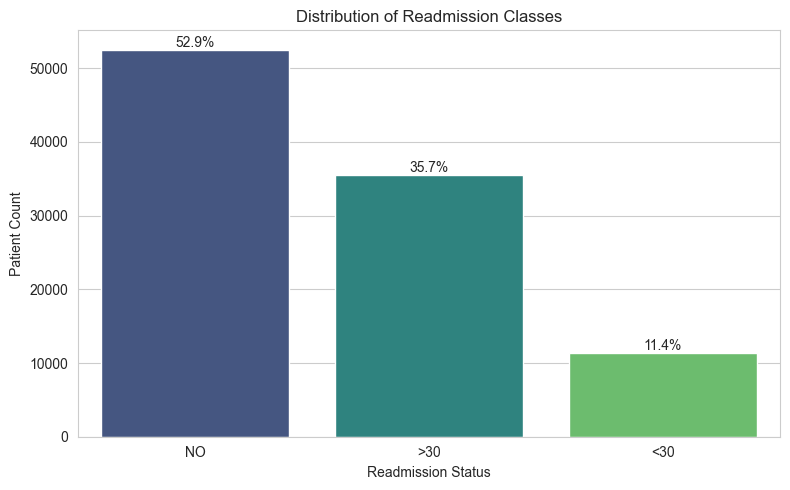


--- 2. Demographic Profiling ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\1960334943.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="age", data=df, palette="coolwarm")


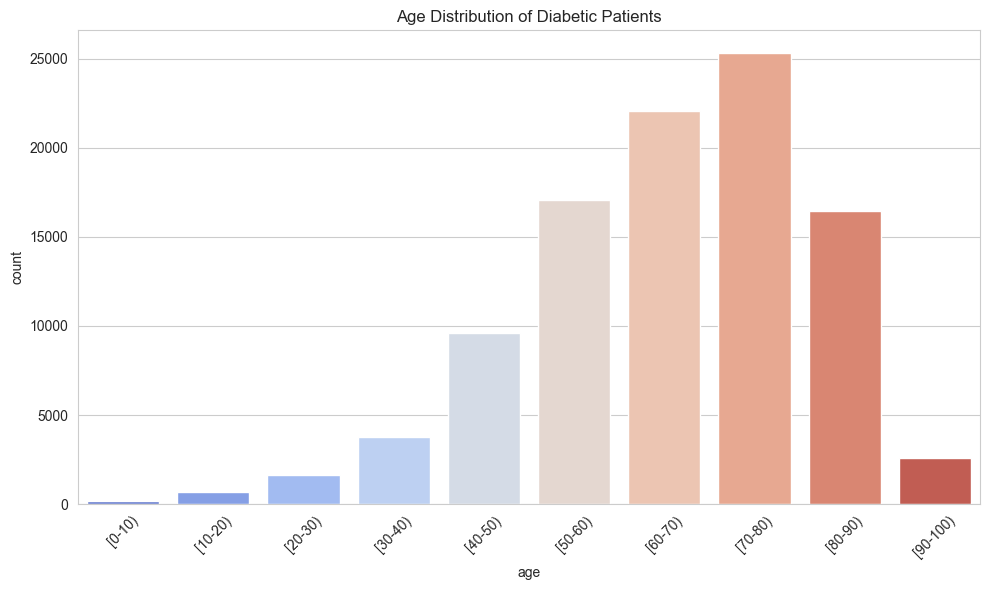

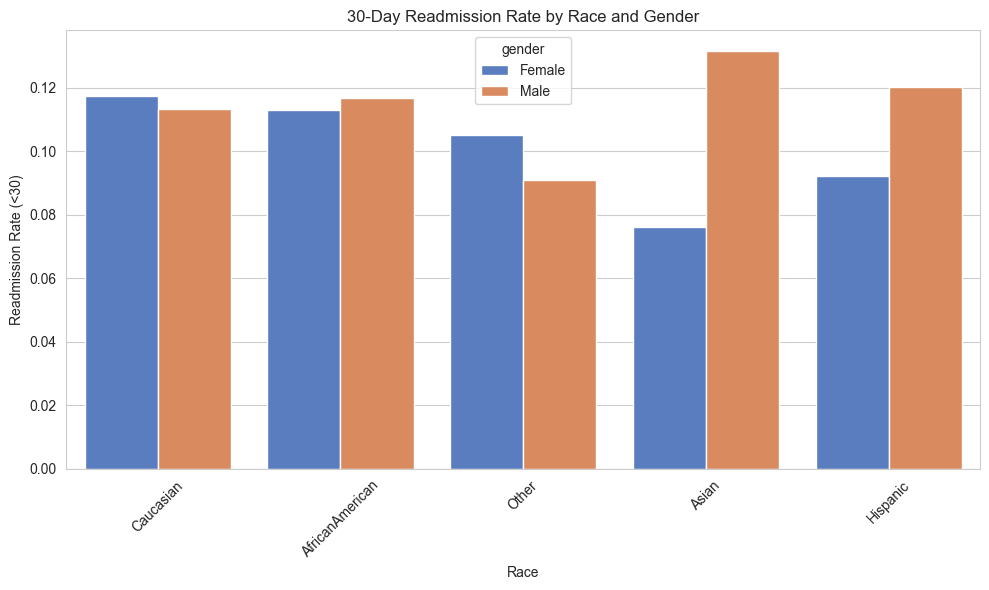


--- 3. Medication Efficacy Analysis ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\1960334943.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


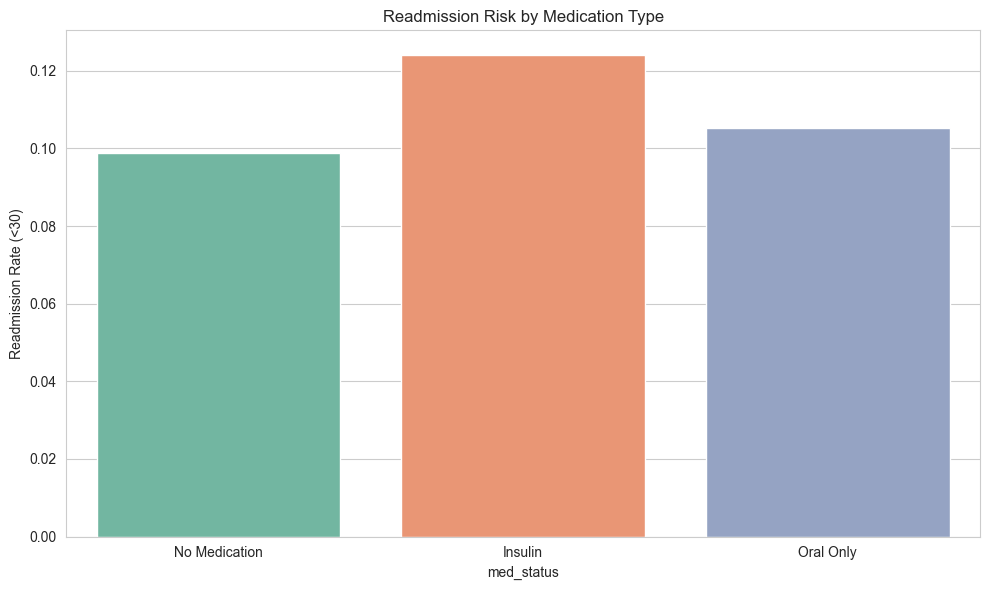

C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\1960334943.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


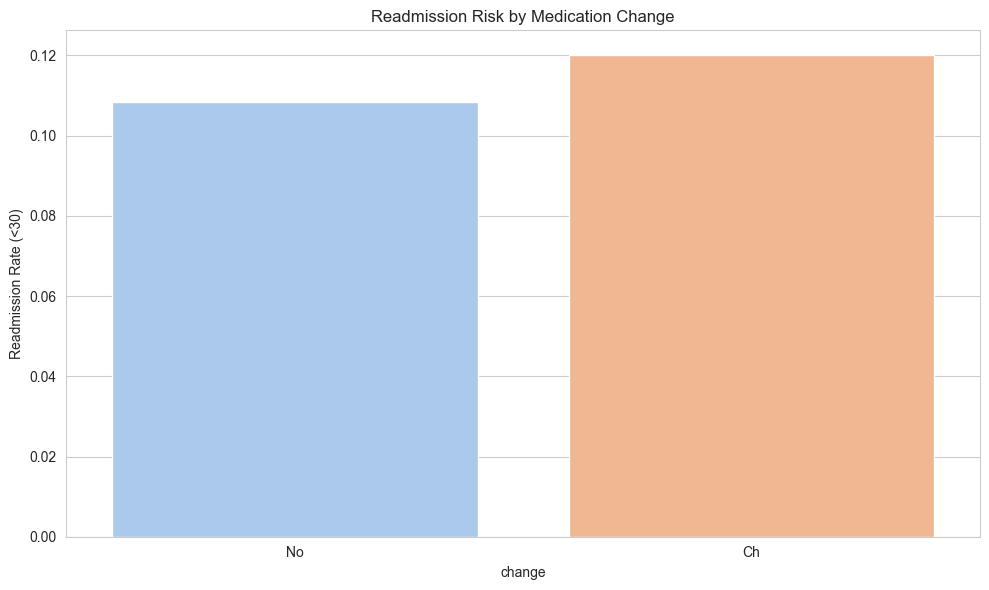


--- 4. Operational Metrics ---


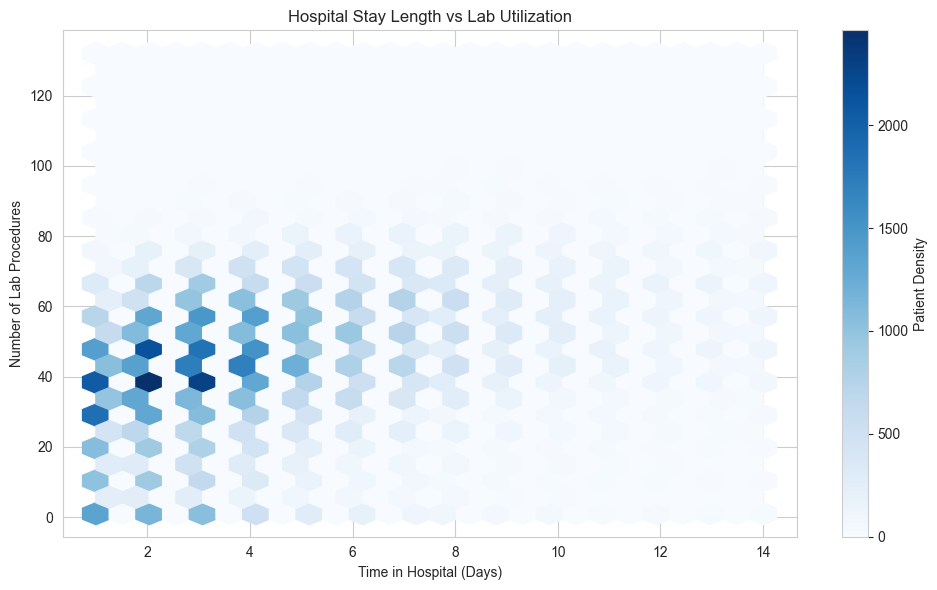

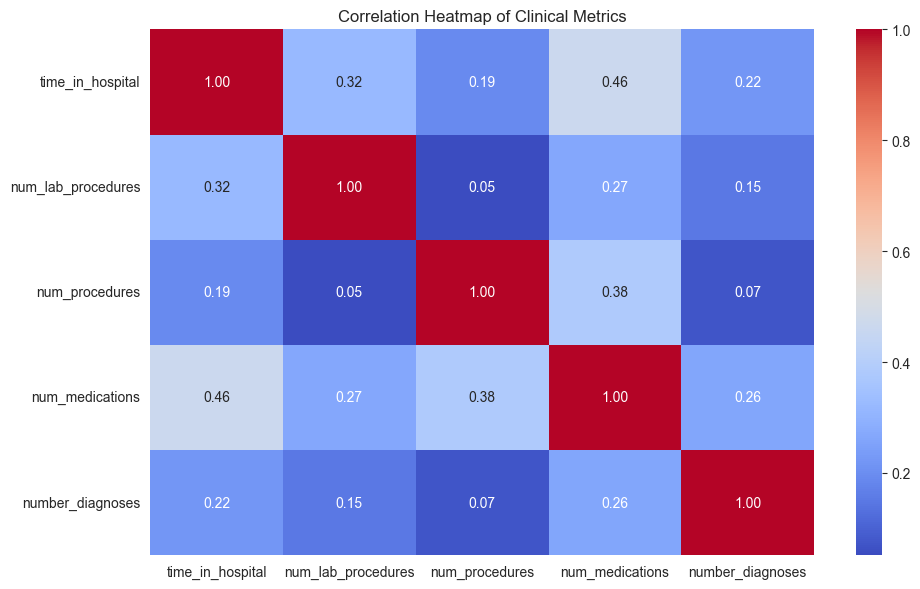

C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\1960334943.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


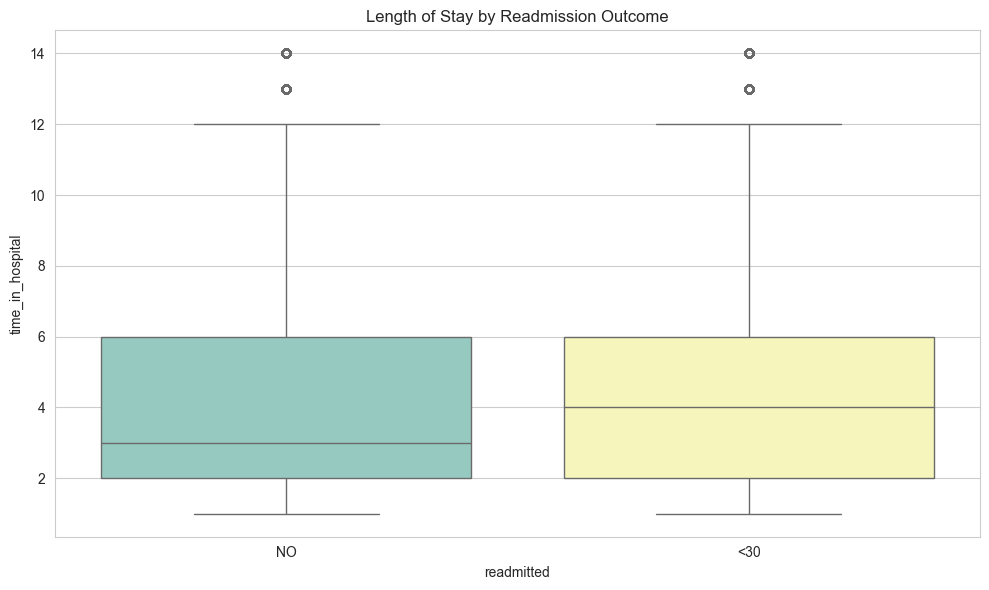

C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\1960334943.py:285: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


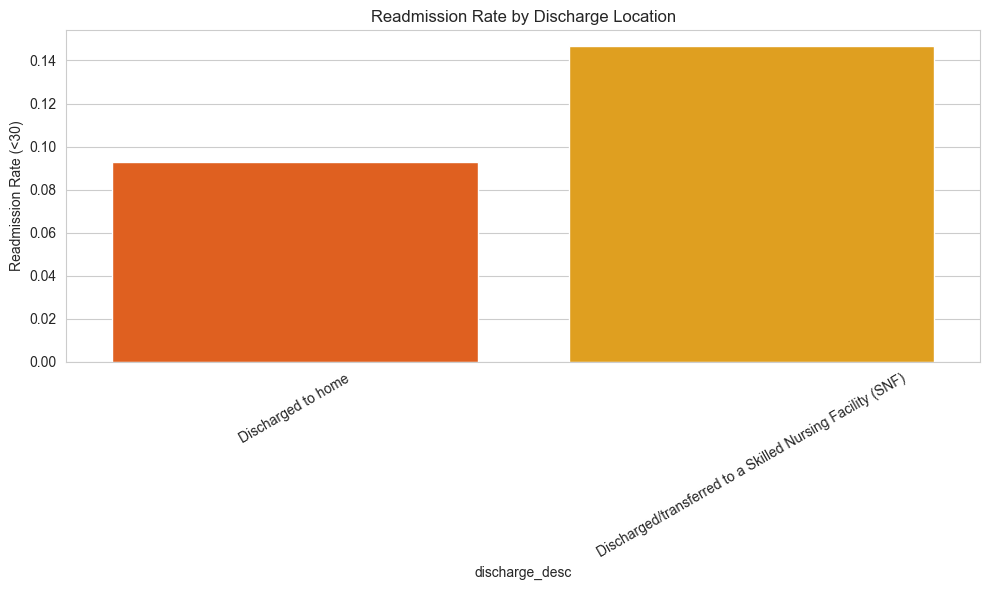


✓ Phase 3 complete. All EDA figures saved to the reports/ directory.


In [4]:
print("\n--- STARTING PHASE 3: EXPLORATORY DATA ANALYSIS (EDA) ---")

# Global Visualization Style

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Output Directory

REPORTS_DIR = "../reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

def save_and_show(filename):
    """
    Save the current matplotlib figure into the reports directory
    and display it inline.
    """
    path = os.path.join(REPORTS_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

# Load Enriched Dataset

DATA_PATH = "../data/processed/diabetic_data_phase2_enriched.csv"
IDS_PATH = "../data/raw/IDs_mapping.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Phase 2 dataset not found. Run Phase 1 and Phase 2 first.")

df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded successfully: {df.shape}")


# Binary Target: 30-day readmission (HRRP focus)

df["readmitted_flag"] = (df["readmitted"] == "<30").astype(int)


# 1. READMISSION LANDSCAPE

print("\n--- 1. Readmission Landscape ---")

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x="readmitted",
    data=df,
    order=["NO", ">30", "<30"],
    palette="viridis"
)

plt.title("Distribution of Readmission Classes")
plt.xlabel("Readmission Status")
plt.ylabel("Patient Count")

# Percentage annotations (class imbalance insight)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height() / len(df) * 100:.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom"
    )

# Insight:
# The <30 group (HRRP penalty class) is a clear minority,
# indicating strong class imbalance. Rate-based analysis
# is therefore preferred over raw counts.

save_and_show("1_readmission_distribution.png")


# 2. DEMOGRAPHIC PROFILING

print("\n--- 2. Demographic Profiling ---")


# Age Distribution

plt.figure()
sns.countplot(x="age", data=df, palette="coolwarm")
plt.title("Age Distribution of Diabetic Patients")
plt.xticks(rotation=45)

# Insight:
# Diabetes prevalence increases with age, with the majority
# of patients clustered in older age brackets.

save_and_show("2_age_distribution.png")


# Readmission by Race & Gender

plt.figure()
sns.barplot(
    x="race",
    y="readmitted_flag",
    hue="gender",
    data=df,
    errorbar=None,
    palette="muted"
)

plt.title("30-Day Readmission Rate by Race and Gender")
plt.ylabel("Readmission Rate (<30)")
plt.xlabel("Race")
plt.xticks(rotation=45)

# Insight:
# Intersectional disparities may exist where the combination
# of race and gender reveals patterns not visible when each
# variable is analyzed independently.

save_and_show("3_readmission_by_race_gender.png")


# 3. MEDICATION EFFICACY ANALYSIS

print("\n--- 3. Medication Efficacy Analysis ---")

# List of known oral diabetes medications (from dataset schema)
oral_meds = [
    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
    'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
    'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
    'examide','citoglipton','glyburide-metformin','glipizide-metformin',
    'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'
]

def classify_medication(row):
    """
    Classify patients into Insulin, Oral Only, or No Medication groups.
    Uses safe access to avoid missing-column errors.
    """
    if row.get("insulin", "No") != "No":
        return "Insulin"
    if any(row.get(med, "No") != "No" for med in oral_meds):
        return "Oral Only"
    return "No Medication"

df["med_status"] = df.apply(classify_medication, axis=1)

plt.figure()
sns.barplot(
    x="med_status",
    y="readmitted_flag",
    data=df,
    errorbar=None,
    palette="Set2"
)

plt.title("Readmission Risk by Medication Type")
plt.ylabel("Readmission Rate (<30)")

# Insight:
# Higher readmission rates among insulin users may reflect
# greater disease severity and clinical instability.

save_and_show("4_readmission_by_medication_type.png")


# Medication Change Analysis

plt.figure()
sns.barplot(
    x="change",
    y="readmitted_flag",
    data=df,
    errorbar=None,
    palette="pastel"
)

plt.title("Readmission Risk by Medication Change")
plt.ylabel("Readmission Rate (<30)")

# Insight:
# Medication changes during hospitalization may signal
# unstable patients requiring closer post-discharge follow-up.

save_and_show("5_readmission_by_medication_change.png")


# 4. OPERATIONAL METRICS

print("\n--- 4. Operational Metrics ---")

# Time in Hospital vs Lab Procedures

plt.figure()
plt.hexbin(
    df["time_in_hospital"],
    df["num_lab_procedures"],
    gridsize=25,
    cmap="Blues"
)
plt.colorbar(label="Patient Density")
plt.xlabel("Time in Hospital (Days)")
plt.ylabel("Number of Lab Procedures")
plt.title("Hospital Stay Length vs Lab Utilization")

# Insight:
# A positive relationship suggests longer stays involve
# greater diagnostic intensity.

save_and_show("6_stay_vs_lab_utilization.png")

# Correlation Heatmap

num_cols = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_diagnoses"
]

plt.figure()
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.title("Correlation Heatmap of Clinical Metrics")

save_and_show("7_clinical_metrics_correlation.png")

# Length of Stay by Readmission (NO vs <30)

df_los = df[df["readmitted"] != ">30"]

plt.figure()
sns.boxplot(
    x="readmitted",
    y="time_in_hospital",
    data=df_los,
    order=["NO", "<30"],
    palette="Set3"
)

plt.title("Length of Stay by Readmission Outcome")

# Insight:
# Readmitted patients tend to show longer initial stays
# and more extreme outliers.

save_and_show("8_los_by_readmission.png")

# Discharge Disposition Analysis

discharge_map = {}

with open(IDS_PATH, "r") as f:
    lines = [line.strip() for line in f if line.strip()]

# Locate the discharge disposition section
start_idx = lines.index("discharge_disposition_id,description") + 1
end_idx = lines.index("admission_source_id,description")

for line in lines[start_idx:end_idx]:
    parts = line.split(",", 1)

    # Skip malformed or empty lines
    if len(parts) != 2:
        continue

    key, value = parts

    # Skip empty or non-numeric IDs (caused by bad CSV formatting)
    if not key.isdigit():
        continue

    discharge_map[int(key)] = value

# Map discharge descriptions to main dataframe
df["discharge_desc"] = df["discharge_disposition_id"].map(discharge_map)

subset = df[df["discharge_desc"].isin([
    "Discharged to home",
    "Discharged/transferred to a Skilled Nursing Facility (SNF)"
])]

plt.figure()
sns.barplot(
    x="discharge_desc",
    y="readmitted_flag",
    data=subset,
    errorbar=None,
    palette="autumn"
)

plt.title("Readmission Rate by Discharge Location")
plt.ylabel("Readmission Rate (<30)")
plt.xticks(rotation=30)

# Insight:
# Patients discharged to Skilled Nursing Facilities
# exhibit higher return rates than those sent home.

save_and_show("9_readmission_by_discharge_location.png")

print("\n✓ Phase 3 complete. All EDA figures saved to the reports/ directory.")


## Phase 4: Feature Engineering — Vitality Complexity Index (VCI)

### Objective
To translate clinical intuition into a programmable risk stratification algorithm that
identifies patients at high risk of 30-day readmission.

### Clinical Motivation
Nursing leadership requires a **simple, interpretable score** to flag complex patients
during hospitalization. Rather than deploying a black-box model, we implement a
simplified variant of the **LACE Index**, a clinically validated readmission risk tool.

### VCI Components
The Vitality Complexity Index (VCI) combines four dimensions of patient complexity:

- **L — Length of Stay:** Proxy for illness severity and care intensity  
- **A — Acuity of Admission:** Emergency and trauma admissions signal instability  
- **C — Comorbidity Burden:** Approximated using number of diagnoses  
- **E — Emergency Visits:** Prior utilization reflects chronic instability  

Each component is scored independently and summed to form `VCI_Score`.
- **Calculation:** VCI_Score = L + A + C + E

### Risk Stratification
Patients are categorized into three clinically meaningful risk tiers:

- **Low Risk:** VCI < 7  
- **Medium Risk:** VCI 7–10  
- **High Risk:** VCI > 10  

The effectiveness of the index is validated by comparing **30-day readmission rates**
across these risk groups. A monotonic increase supports the clinical usefulness of the score.


--- STARTING PHASE 4: VITALITY COMPLEXITY INDEX (VCI) ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\3288544628.py:14: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)
C:\Users\gamit\AppData\Local\Temp\ipykernel_28256\3288544628.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Dataset loaded successfully: (99343, 50)
Calculating VCI component scores...

VCI Risk Category Distribution (Proportion of Patients):
VCI_Risk_Category
Medium Risk    0.520
Low Risk       0.282
High Risk      0.198
Name: proportion, dtype: float64

VCI Validation Table:
                   Readmission Rate (<30 %)
VCI_Risk_Category                          
Low Risk                               8.82
Medium Risk                           11.45
High Risk                             14.89


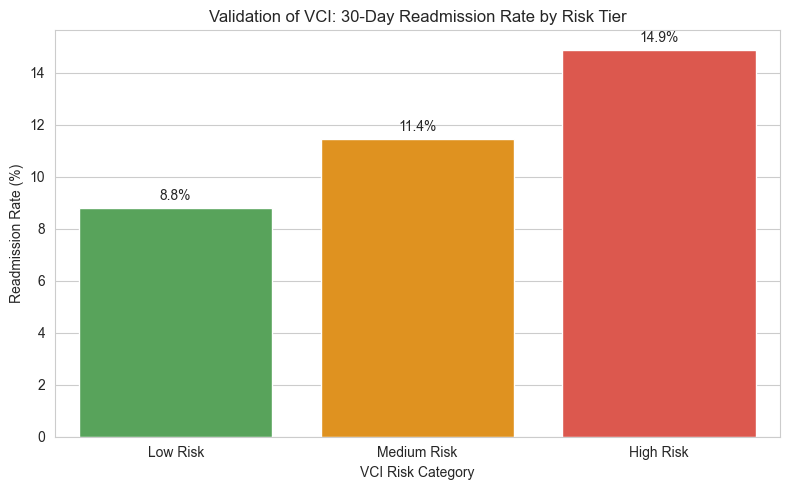


✓ Phase 4 complete. VCI successfully implemented and validated.


In [5]:
print("\n--- STARTING PHASE 4: VITALITY COMPLEXITY INDEX (VCI) ---")

# Configuration

DATA_PATH = "../data/processed/diabetic_data_phase2_enriched.csv"
REPORTS_DIR = "../reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

# Load Dataset

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Phase 2 dataset not found. Run Phase 1–3 first.")

df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded successfully: {df.shape}")


# Ensure Numeric Types (Defensive Programming)

# These conversions ensure scoring logic does not fail
df["time_in_hospital"] = pd.to_numeric(df["time_in_hospital"], errors="coerce")
df["admission_type_id"] = pd.to_numeric(df["admission_type_id"], errors="coerce")
df["number_diagnoses"] = pd.to_numeric(df["number_diagnoses"], errors="coerce")
df["number_emergency"] = pd.to_numeric(df["number_emergency"], errors="coerce")


# VCI SCORING FUNCTIONS
# Each component is modular, testable, and clinically interpretable

def calculate_L_points(days):
    """
    L — Length of Stay Score
    Longer hospital stays indicate greater illness severity
    and higher care complexity.
    """
    if days <= 0:
        return 0
    elif 1 <= days <= 4:
        return 1
    elif 5 <= days <= 13:
        return 4
    else:
        return 7  # >= 14 days

def calculate_A_points(admission_id):
    """
    A — Acuity of Admission
    Emergency or Trauma admissions indicate higher immediate risk.
    """
    return 3 if admission_id in [1, 7] else 0

def calculate_C_points(num_diagnoses):
    """
    C — Comorbidity Burden (Proxy)
    Uses number of diagnoses as a simplified indicator of
    chronic disease complexity.
    """
    if num_diagnoses < 4:
        return 0
    elif 4 <= num_diagnoses <= 7:
        return 3
    else:
        return 5  # >= 8 diagnoses

def calculate_E_points(num_emergency):
    """
    E — Emergency Visit Intensity
    Frequent emergency visits suggest patient instability
    and poor outpatient disease control.
    """
    if num_emergency == 0:
        return 0
    elif 1 <= num_emergency <= 4:
        return 3
    else:
        return 5  # > 4 visits

def assign_risk_category(score):
    """
    Stratify patients into actionable clinical risk tiers
    based on total VCI score.
    """
    if score < 7:
        return "Low Risk"
    elif 7 <= score <= 10:
        return "Medium Risk"
    else:
        return "High Risk"


# APPLY VCI FRAMEWORK

print("Calculating VCI component scores...")

df["L_points"] = df["time_in_hospital"].apply(calculate_L_points)
df["A_points"] = df["admission_type_id"].apply(calculate_A_points)
df["C_points"] = df["number_diagnoses"].apply(calculate_C_points)
df["E_points"] = df["number_emergency"].apply(calculate_E_points)

# Total VCI Score
df["VCI_Score"] = (
    df["L_points"]
    + df["A_points"]
    + df["C_points"]
    + df["E_points"]
)

# Risk Stratification
df["VCI_Risk_Category"] = df["VCI_Score"].apply(assign_risk_category)


# DISTRIBUTION CHECK

print("\nVCI Risk Category Distribution (Proportion of Patients):")
print(df["VCI_Risk_Category"].value_counts(normalize=True).round(3))

# Insight:
# A balanced distribution ensures the index meaningfully
# separates patients rather than collapsing into one group.


# VALIDATION: READMISSION RATE BY RISK TIER

# Create binary target if not already present
df["readmitted_flag"] = (df["readmitted"] == "<30").astype(int)

validation = (
    df.groupby("VCI_Risk_Category")["readmitted_flag"]
      .mean()
      .mul(100)
      .reindex(["Low Risk", "Medium Risk", "High Risk"])
)

print("\nVCI Validation Table:")
print(validation.round(2).to_frame("Readmission Rate (<30 %)"))


# VISUAL VALIDATION

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

sns.barplot(
    x=validation.index,
    y=validation.values,
    errorbar=None,
    palette=["#4CAF50", "#FF9800", "#F44336"]
)

plt.title("Validation of VCI: 30-Day Readmission Rate by Risk Tier")
plt.xlabel("VCI Risk Category")
plt.ylabel("Readmission Rate (%)")

# Annotate values
for i, v in enumerate(validation.values):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.savefig(
    os.path.join(REPORTS_DIR, "10_vci_readmission_validation.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# Insight:
# A monotonic increase in readmission rate from Low → High Risk
# demonstrates that the VCI successfully stratifies patients
# by clinical complexity and readmission vulnerability.

print("\n✓ Phase 4 complete. VCI successfully implemented and validated.")
